2024-03-14 23:10:41,132 - INFO - Configuration loaded successfully.
2024-03-14 23:10:41,167 - INFO - Feature-engineered dataset successfully loaded.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


2024-03-14 23:12:45,357 - INFO - Accuracy: 0.7338, Precision: 0.6207, Recall: 0.6545, F1 Score: 0.6372, ROC AUC: 0.8167


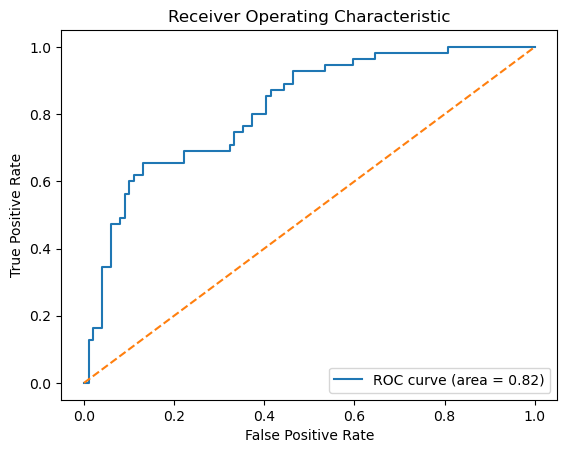

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
from joblib import dump
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import logging

# Add the Helpers directory to the path
helpers_path = Path("../Helpers").resolve()
sys.path.append(str(helpers_path))

from data_helpers import load_config, load_data

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def load_feature_engineered_data(config_path):
    """Loads feature-engineered dataset from the specified configuration path."""
    try:
        config = load_config(config_path)
        processed_data_path = config['processed_data_path']
        df = pd.read_csv(processed_data_path)
        logging.info("Feature-engineered dataset successfully loaded.")
        return df
    except Exception as e:
        logging.error(f"Failed to load feature-engineered dataset: {e}")
        return None

def evaluate_model_performance(model, X_test, y_test):
    """Evaluates the model's performance and prints various metrics."""
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Log metrics
    logging.info(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, ROC AUC: {roc_auc:.4f}")
    
    # Plot ROC curve
    plot_roc_curve(y_test, y_pred_proba)

def plot_roc_curve(y_test, y_pred_proba):
    """Plots the ROC curve for a given set of true labels and predictions."""
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

def perform_hyperparameter_tuning(X_train, y_train):
    """Performs hyperparameter tuning for the XGBoost model."""
    param_distributions = {
        'n_estimators': np.arange(50, 401, 50),
        'max_depth': np.arange(3, 11),
        'learning_rate': np.linspace(0.01, 0.2, 10)
    }
    
    xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    random_search = RandomizedSearchCV(
        estimator=xgb_model,
        param_distributions=param_distributions,
        n_iter=100,
        scoring='roc_auc',
        cv=5,
        random_state=42,
        verbose=1
    )
    
    random_search.fit(X_train, y_train)
    return random_search.best_estimator_

if __name__ == "__main__":
    config_path = '../config/config.json'
    df = load_feature_engineered_data(config_path)
    if df is not None:
        X = df.drop('Outcome', axis=1)
        y = df['Outcome']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Perform hyperparameter tuning
        best_xgb_model = perform_hyperparameter_tuning(X_train, y_train)
        
        # Evaluate the best model
        evaluate_model_performance(best_xgb_model, X_test, y_test)
        
        # Serialize the model
        dump(best_xgb_model, 'best_model_xgboost.joblib')
